Acurácia final no conjunto de teste: 0.86%
Loss final no conjunto de teste: 0.4145
Número de erros: 100000
Classe 0 frequentemente confundida com 2 (35 vezes)
Classe 0 frequentemente confundida com 3 (70 vezes)
Classe 0 frequentemente confundida com 6 (50 vezes)
Classe 1 frequentemente confundida com 3 (27 vezes)
Classe 2 frequentemente confundida com 4 (168 vezes)
Classe 2 frequentemente confundida com 6 (49 vezes)
Classe 3 frequentemente confundida com 0 (21 vezes)
Classe 4 frequentemente confundida com 2 (60 vezes)
Classe 4 frequentemente confundida com 3 (44 vezes)
Classe 4 frequentemente confundida com 6 (50 vezes)
Classe 5 frequentemente confundida com 7 (66 vezes)
Classe 5 frequentemente confundida com 9 (28 vezes)
Classe 6 frequentemente confundida com 0 (211 vezes)
Classe 6 frequentemente confundida com 2 (127 vezes)
Classe 6 frequentemente confundida com 3 (47 vezes)
Classe 6 frequentemente confundida com 4 (87 vezes)
Classe 7 frequentemente confundida com 9 (38 vezes)
Classe 9 frequentemente confundida com 7 (54 vezes)

In [23]:
import os
import sys
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np

from src.data.data_loader import DataLoader
from src.models.mlp import MLP
from src.trainers.trainer import Trainer
from src.utils.metrics import Metrics

def load_data():
    x_train, y_train = DataLoader.load_fashion_mnist("src/data/fashion_train.csv")
    x_test, y_test = DataLoader.load_fashion_mnist("src/data/fashion_test.csv")
    return x_train, y_train, x_test, y_test

def build_model():
    return MLP(
        input_size=784,
        hidden_size=128,
        output_size=10,
        activation="relu",
        learning_rate=0.01,
        momentum=0.0,
        use_bias=True,
        weight_init="he",
        optimizer="adam",
        l1_lambda=0.0001,
        l2_lambda=0.001,
        dropout_rate=0.2,
    )

def train_model(model, x_train, y_train, x_test, y_test):
    trainer = Trainer(
        model=model,
        batch_size=32,
        epochs=50,
        validation_data=(x_test, y_test),
    )
    history = trainer.train(x_train, y_train)
    return trainer, history

def evaluate_and_predict(model, trainer, x_test, y_test):
    test_loss, test_acc = trainer.evaluate(x_test, y_test)
    y_pred_probs = model.predict(x_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_test_labels = np.argmax(y_test, axis=1)
    return y_pred_probs, y_pred, y_test_labels, test_loss, test_acc

def plot_classification_errors(x_test, y_true, y_pred, wrong_indices,
                               class_names, num_to_show=12, cols=4):
    import matplotlib.pyplot as plt
    import numpy as np

    rows = int(np.ceil(num_to_show / cols))
    plt.figure(figsize=(3.2*cols, 3.5*rows), constrained_layout=True)

    for k, idx in enumerate(wrong_indices[:num_to_show]):
        plt.subplot(rows, cols, k + 1)
        plt.imshow(x_test[idx].reshape(28, 28), cmap="gray")
        plt.axis("off")

        true_label = class_names[y_true[idx]]
        pred_label = class_names[y_pred[idx]]

        plt.title(f"Real: {true_label}\nPred: {pred_label}",
                  fontsize=9, color="tab:red", loc="left")

    plt.suptitle("Exemplos de Classificações Incorretas",
                 fontsize=16, y=1.02)
    plt.show()


In [22]:
def main():
    x_train, y_train, x_test, y_test = load_data()
    model = build_model()
    trainer, history = train_model(model, x_train, y_train, x_test, y_test)

    y_pred_probs, y_pred, y_test_labels, test_loss, test_acc = evaluate_and_predict(
        model, trainer, x_test, y_test
    )
    
    print("Iniciando treinamento...")
    trainer = Trainer(
        model=model,
        batch_size=32,
        epochs=50,
        validation_data=(x_test, y_test),
    )

    history = trainer.train(x_train, y_train)

    # Avaliar modelo
    print("Avaliando modelo...")
    test_loss, test_acc = trainer.evaluate(x_test, y_test)
    print(f"Acurácia final no conjunto de teste: {test_acc:.2f}%")
    print(f"Loss final no conjunto de teste: {test_loss:.4f}")

    # Plotar curvas de loss e acurácia
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history["loss"], label="Treino")
    plt.plot(history["val_loss"], label="Validação")
    plt.title("Loss durante o treinamento")
    plt.xlabel("Época")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history["accuracy"], label="Treino")
    plt.plot(history["val_accuracy"], label="Validação")
    plt.title("Acurácia durante o treinamento")
    plt.xlabel("Época")
    plt.ylabel("Acurácia (%)")
    plt.legend()

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    plt.savefig(f"imgs/results_{timestamp}.png")
    plt.show()

    # Gerar previsões e converter para rótulos
    y_pred_probs = model.predict(x_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_test_labels = np.argmax(y_test, axis=1)
    wrong_indices = np.where(y_pred != y_test_labels)[0]
    print(f"Número de erros: {len(wrong_indices)}")
    
    # Gerar e mostrar matriz de confusão
    cm = Metrics.confusion_matrix(y_test_labels, y_pred)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title("Matriz de Confusão")
    plt.colorbar()
    tick_marks = np.arange(cm.shape[0])
    plt.xticks(tick_marks, tick_marks)
    plt.yticks(tick_marks, tick_marks)
    plt.xlabel("Classe Predita")
    plt.ylabel("Classe Real")
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(
                j,
                i,
                str(cm[i, j]),
                ha="center",
                va="center",
                color="white" if cm[i, j] > thresh else "black",
                fontsize=12,
            )
    plt.savefig(f"imgs/confusion_matrix_{timestamp}.png")
    plt.tight_layout()
    plt.show()

    num_to_show = 10
    cols = 5
    rows = num_to_show // cols + int(num_to_show % cols != 0)
    plt.figure(figsize=(12, 6))
    for i, idx in enumerate(wrong_indices[:num_to_show]):
        plt.subplot(rows, cols, i + 1)
        image = x_test[idx].reshape(28, 28)
        plt.imshow(image, cmap="gray")
        plt.title(f"V:{y_test[idx]}\nP:{y_pred[idx]}", fontsize=10)
        plt.axis("off")
    plt.suptitle("Exemplos de Classificações Incorretas", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # Identificar pares mais confundidos
    confused_pairs = np.argwhere((cm > 20) & (np.eye(10) == 0))
    print("\nPares de classes frequentemente confundidas:")
    for i, j in confused_pairs:
        print(f"Classe {i} frequentemente confundida com {j} ({cm[i, j]} vezes)")


In [18]:
def visualize_results(model, history, x_test, y_test, y_pred_probs, y_pred, y_test_labels):
    import matplotlib.pyplot as plt

    # --- Plot losses e acurácia
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history["loss"], label="Treino")
    plt.plot(history["val_loss"], label="Validação")
    plt.title("Loss durante o treinamento")
    plt.xlabel("Época")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history["accuracy"], label="Treino")
    plt.plot(history["val_accuracy"], label="Validação")
    plt.title("Acurácia durante o treinamento")
    plt.xlabel("Época")
    plt.ylabel("Acurácia (%)")
    plt.legend()

    plt.tight_layout()
    plt.show()

    # --- Matriz de confusão
    from src.utils.metrics import Metrics
    cm = Metrics.confusion_matrix(y_test_labels, y_pred)

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title("Matriz de Confusão")
    plt.colorbar()
    tick_marks = np.arange(10)
    plt.xticks(tick_marks, tick_marks)
    plt.yticks(tick_marks, tick_marks)

    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, str(cm[i, j]),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.xlabel("Classe Predita")
    plt.ylabel("Classe Real")
    plt.tight_layout()
    plt.show()

    # --- Exibir imagens incorretas
    wrong_indices = np.where(y_pred != y_test_labels)[0]
    print(f"Número de erros: {len(wrong_indices)}")

    class_names = [
        "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
        "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
    ]

    plot_classification_errors(
        x_test, y_test_labels, y_pred, wrong_indices,
        class_names, num_to_show=12, cols=4
    )


Epoch 1/50, Loss: 2.7310, Acc: 0.7755, Val Loss: 0.5755, Val Acc: 0.8287, lr: 0.01
Epoch 2/50, Loss: 3.2051, Acc: 0.8279, Val Loss: 0.6744, Val Acc: 0.7674, lr: 0.01
Epoch 3/50, Loss: 2.6751, Acc: 0.8388, Val Loss: 0.5246, Val Acc: 0.8161, lr: 0.01
Epoch 4/50, Loss: 2.4710, Acc: 0.8434, Val Loss: 0.4608, Val Acc: 0.8521, lr: 0.01
Epoch 5/50, Loss: 2.3606, Acc: 0.8489, Val Loss: 0.4158, Val Acc: 0.8533, lr: 0.01
Epoch 6/50, Loss: 2.3623, Acc: 0.8483, Val Loss: 0.4477, Val Acc: 0.8487, lr: 0.01
Epoch 7/50, Loss: 2.3674, Acc: 0.8486, Val Loss: 0.3998, Val Acc: 0.8636, lr: 0.01
Epoch 8/50, Loss: 2.3717, Acc: 0.8509, Val Loss: 0.4093, Val Acc: 0.8555, lr: 0.01
Epoch 9/50, Loss: 2.3598, Acc: 0.8510, Val Loss: 0.4322, Val Acc: 0.8493, lr: 0.01
Epoch 10/50, Loss: 2.3480, Acc: 0.8532, Val Loss: 0.3879, Val Acc: 0.8632, lr: 0.01
Epoch 11/50, Loss: 2.3910, Acc: 0.8520, Val Loss: 0.3909, Val Acc: 0.8608, lr: 0.01
Epoch 12/50, Loss: 2.3665, Acc: 0.8532, Val Loss: 0.4032, Val Acc: 0.8564, lr: 0.01
E

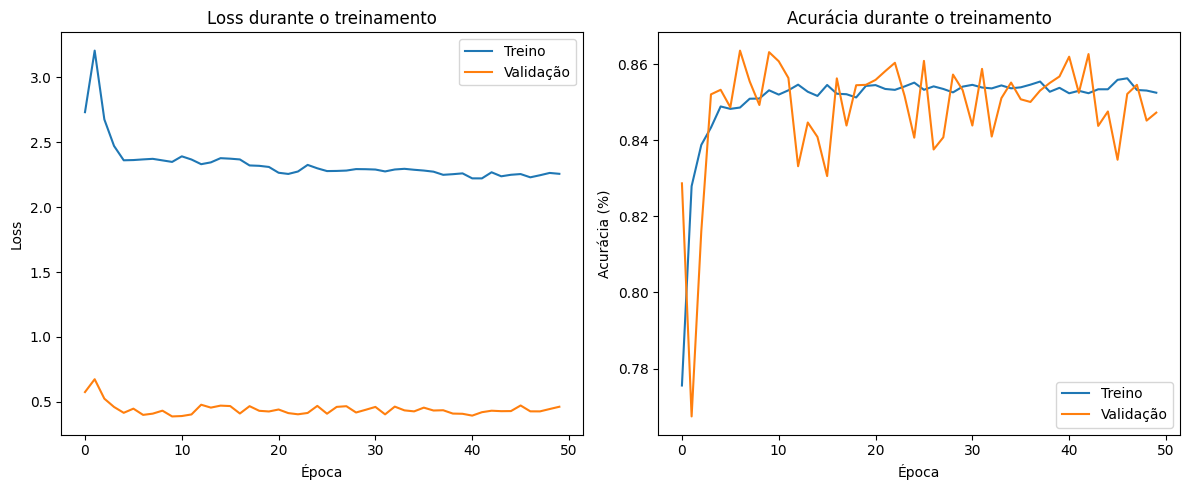

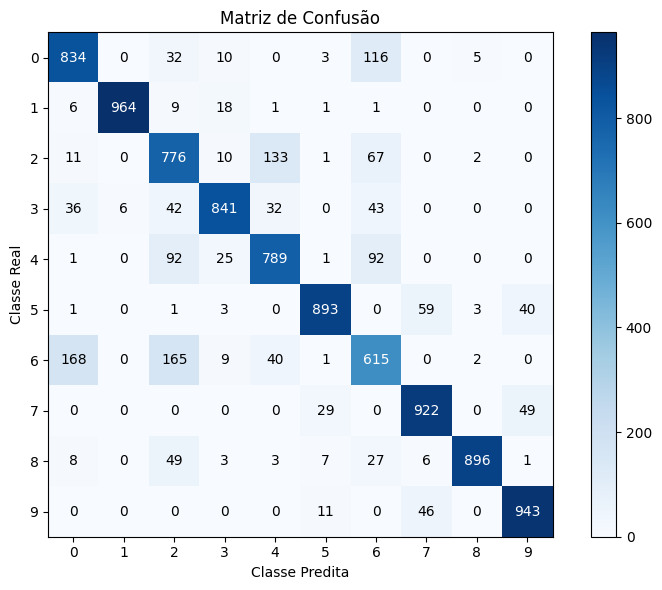

Número de erros: 1527


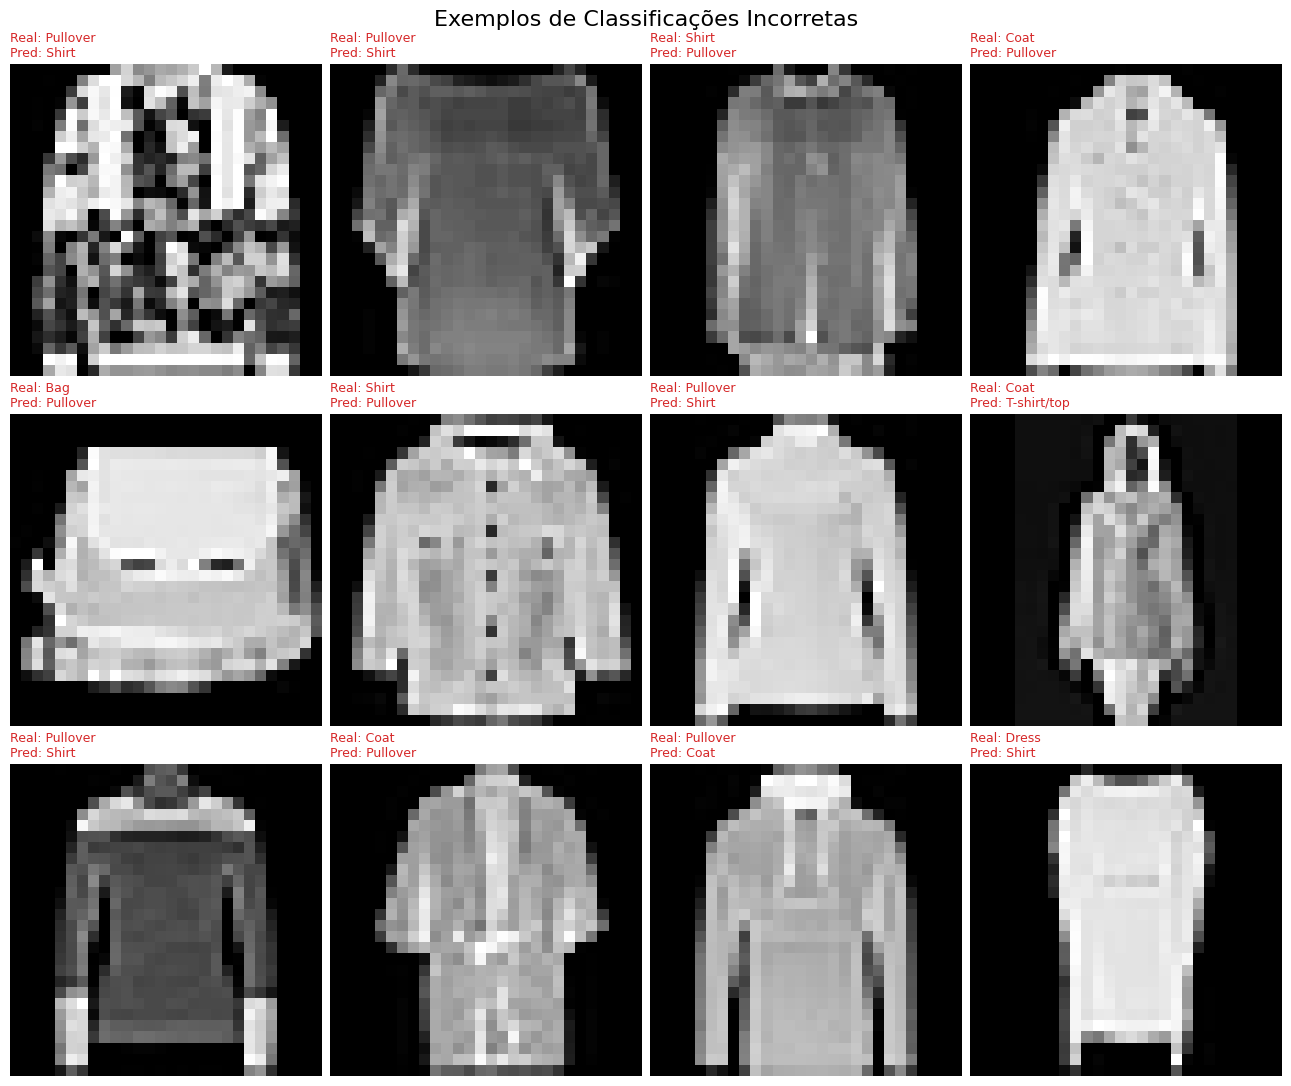

In [24]:
x_train, y_train, x_test, y_test = load_data()
model = build_model()
trainer, history = train_model(model, x_train, y_train, x_test, y_test)

y_pred_probs, y_pred, y_test_labels, test_loss, test_acc = evaluate_and_predict(
    model, trainer, x_test, y_test
)

# Agora sim, mostra tudo
visualize_results(model, history, x_test, y_test, y_pred_probs, y_pred, y_test_labels)

In [25]:
from sklearn.metrics import classification_report
print(classification_report(y_test_labels, y_pred, target_names=class_names))


              precision    recall  f1-score   support

 T-shirt/top       0.78      0.83      0.81      1000
     Trouser       0.99      0.96      0.98      1000
    Pullover       0.67      0.78      0.72      1000
       Dress       0.92      0.84      0.88      1000
        Coat       0.79      0.79      0.79      1000
      Sandal       0.94      0.89      0.92      1000
       Shirt       0.64      0.61      0.63      1000
     Sneaker       0.89      0.92      0.91      1000
         Bag       0.99      0.90      0.94      1000
  Ankle boot       0.91      0.94      0.93      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



In [27]:
cm = Metrics.confusion_matrix(y_test_labels, y_pred)
cm_no_diag = cm.copy()
np.fill_diagonal(cm_no_diag, 0)                 # zera acertos
top_pairs_idx = np.dstack(np.unravel_index(
                     np.argsort(cm_no_diag, axis=None)[::-1], cm_no_diag.shape))[0]

top_n = 5
print("Top pares confundidos (Real → Predito):")
for k in range(top_n):
    i, j = top_pairs_idx[k]
    print(f"{class_names[i]}  →  {class_names[j]}  ({cm[i, j]} vezes)")


Top pares confundidos (Real → Predito):
Shirt  →  T-shirt/top  (168 vezes)
Shirt  →  Pullover  (165 vezes)
Pullover  →  Coat  (133 vezes)
T-shirt/top  →  Shirt  (116 vezes)
Coat  →  Shirt  (92 vezes)


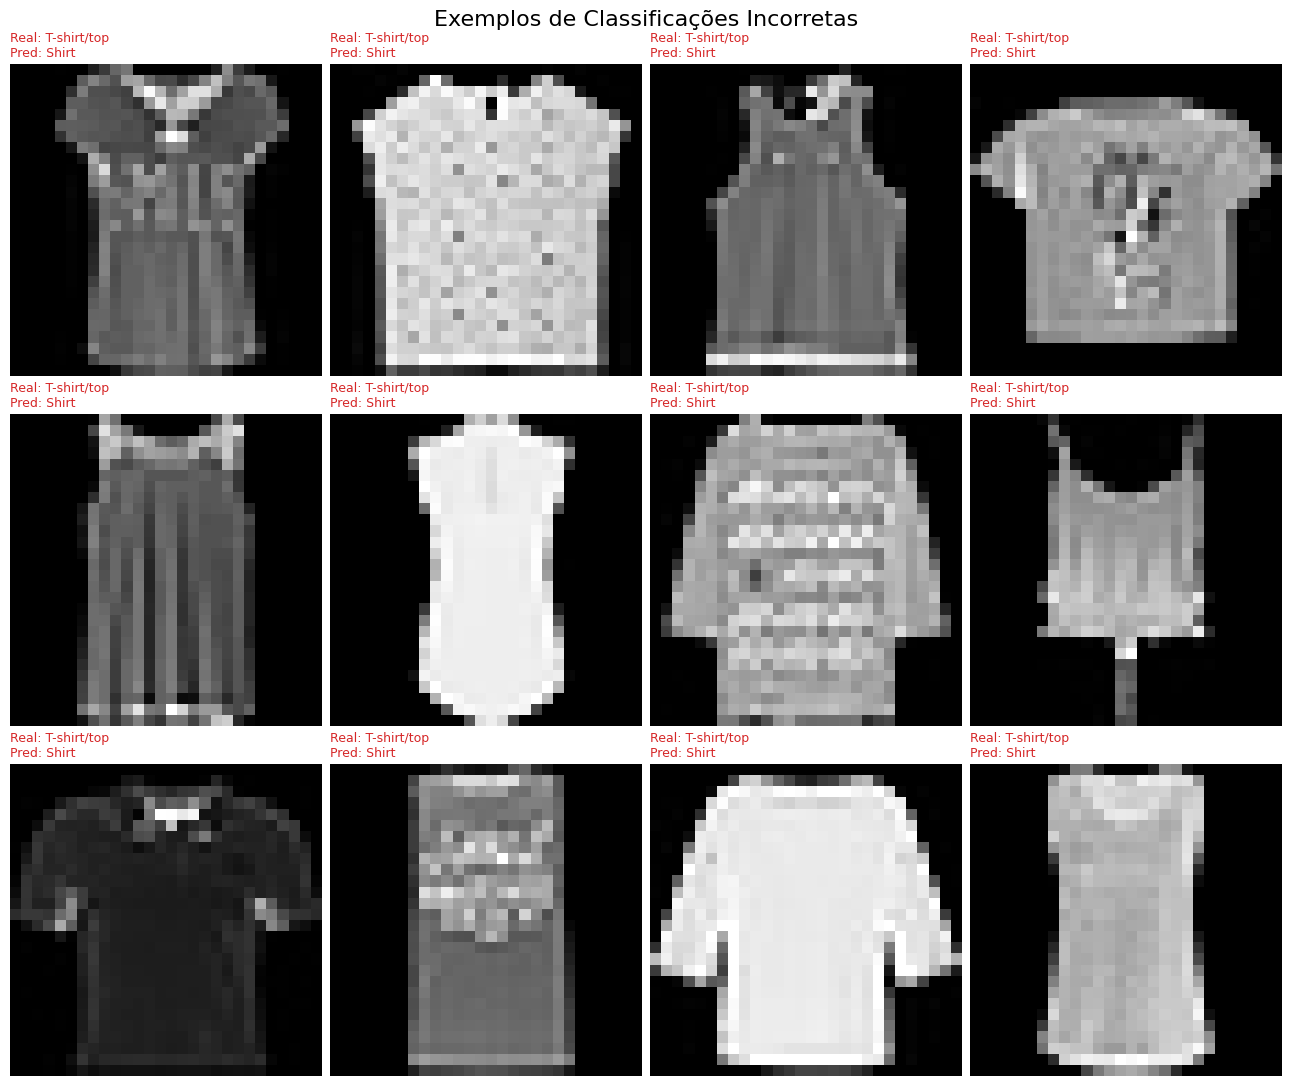

In [ ]:
pair = (0, 6)                       
indices_pair = np.where((y_test_labels == pair[0]) & (y_pred == pair[1]))[0]

plot_classification_errors(x_test, y_test_labels, y_pred,
                           indices_pair, class_names,
                           num_to_show=12, cols=4)


Data Augmentation rapidinho kkk

In [ ]:
x_train, y_train, x_test, y_test = load_data()

x_train_img = x_train.reshape(-1, 28, 28, 1).astype("float32") / 255.0
x_test_img  = x_test.reshape(-1, 28, 28, 1).astype("float32") / 255.0

y_train_labels = np.argmax(y_train, axis=1) 
y_test_labels  = np.argmax(y_test,  axis=1)

In [36]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Aumento leve global (para todo o dataset)
datagen_all = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True
)

# Selecionar apenas exemplos com rótulos 0 (T-shirt) ou 6 (Shirt)
mask_0_6 = np.isin(y_train_labels, [0, 6])
x_pair = x_train_img[mask_0_6]
y_pair = y_train[mask_0_6]

# Gerador extra só para essas classes
datagen_pair = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True
)

flow_pair = datagen_pair.flow(x_pair, y_pair, batch_size=32)
steps_extra = 2 * len(x_pair) // 32  # duplicar aproximadamente


In [ ]:
augmented_x = []
augmented_y = []

num_batches = 2 * len(x_pair) // 32  # por exemplo: duplicar

for _ in range(num_batches):
    xb, yb = next(flow_pair)
    augmented_x.append(xb)
    augmented_y.append(yb)

augmented_x = np.concatenate(augmented_x)
augmented_y = np.concatenate(augmented_y)


AttributeError: 'NumpyArrayIterator' object has no attribute 'next'

In [39]:
model = build_model()  # ou build_model() se quiser manter a MLP
history = model.fit(
    mixed_generator(),
    epochs=20,
    steps_per_epoch=(len(x_train_img) // 32) + steps_extra,
    validation_data=(x_test_img, y_test),
    verbose=1
)

AttributeError: 'MLP' object has no attribute 'fit'